In [87]:
#Importing the dependancies we will need. 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [88]:
#Reads data from Melbourne Housing and Poperty Sales of Melbourne City. 
dataset1 = pd.read_csv("datasets/Melbourne_housing_FULL.csv")
dataset2 = pd.read_csv("datasets/PSMS.csv")

In [89]:
#Takes our two datasets and merges them together into one. 
mergedData = pd.merge(dataset1,dataset2,how='outer')
mergedData.to_csv("MergedDataset.csv", index = False)

In [90]:
# Exploring the shape of our initial dataset. Output shows that our intial dataset has 53K rows. 
# Also looking at NaN values which shows that a lot of values are missing for our data. 
mergedData.shape
mergedData.isnull().sum()


Suburb               0
Address              0
Rooms                0
Type                 0
Price             7610
Method               0
SellerG              0
Date                 0
Distance             2
Postcode             2
Bedroom2         11686
Bathroom         11697
Car              12304
Landsize         16603
BuildingArea     31749
YearBuilt        28744
CouncilArea       6166
Lattitude        11308
Longtitude       11308
Regionname           4
Propertycount        4
KeyID            34857
dtype: int64

In [91]:
# To start processing we are going to drop irrellevant columns that we think don't correlate to price and will make our model perform worse. 
# We are also doing this now to hopefully thing down the amount of potential NaN values in our dataset which we will remove in the next step.
# Finally, we will drop any duplicates. This narrows our dataset to roughly 34K values. 
data = mergedData.drop(["Date","Lattitude", "Suburb", "KeyID","Address", "Method", "SellerG","Postcode", "CouncilArea", "YearBuilt"], axis = 1)
data.drop_duplicates(inplace = True)
data.shape

(33942, 12)

In [92]:
# We want to drop any Not a number values from our dataset but doing so as the data stands now will leave us with only 9K values to train our model off. 
# Let's explore where these NaN values are coming from again, and decide how we will deal with them.
data.isnull().sum()

Rooms                0
Type                 0
Price             6877
Distance             2
Bedroom2          7344
Bathroom          7353
Car               7855
Landsize         10928
BuildingArea     20225
Longtitude        7103
Regionname           4
Propertycount        4
dtype: int64

In [93]:
# Notice that 20K values dont have a building area and 10K haven't got a landsize. 
# These are definitely correlative to price which is our target value but we cant use them. 
# We can handle this by filling the rows with some value. 
# We could use the average, but for a dataset like ours and given the model we want to build it doesnt really make sense to do that
# The range is much too large and would give us a lot of inaccurate rows. 


In [94]:
# Instead lets try and use K-means nearest neighbour method that will fill missing values based on similar rows in the dataset. 

from sklearn.impute import KNNImputer

similarFeatures = ['Landsize', 'Bedroom2', 'Rooms', 'BuildingArea']
imputer = KNNImputer(n_neighbors=5)
dataSubset = data[similarFeatures]
dataImputed = imputer.fit_transform(dataSubset)
dataImputed = pd.DataFrame(dataImputed, columns=similarFeatures)
data['BuildingArea'] = data['BuildingArea'].fillna(dataImputed['BuildingArea'])



In [95]:
# From this we successfully recovered about 13 thousand values from the BuildingArea column, lets do some other important columns now too. 
data.isnull().sum()


Rooms                0
Type                 0
Price             6877
Distance             2
Bedroom2          7344
Bathroom          7353
Car               7855
Landsize         10928
BuildingArea      7370
Longtitude        7103
Regionname           4
Propertycount        4
dtype: int64

In [96]:

similarFeatures = ['Landsize', 'Bedroom2', 'Rooms', 'BuildingArea']
imputer = KNNImputer(n_neighbors=5)
dataSubset = data[similarFeatures]
dataImputed = imputer.fit_transform(dataSubset)
dataImputed = pd.DataFrame(dataImputed, columns=similarFeatures)
data['Landsize'] = data['Landsize'].fillna(dataImputed['Landsize'])



In [97]:
# We recovered another 7k values. 
data.isnull().sum()


Rooms               0
Type                0
Price            6877
Distance            2
Bedroom2         7344
Bathroom         7353
Car              7855
Landsize         3950
BuildingArea     7370
Longtitude       7103
Regionname          4
Propertycount       4
dtype: int64

In [98]:
#Now that we have recovered some data let's drop the NaN values.
# By using the K-Nearest method to fill in some missing values we improved the volume of data to train our dataset on. 

cleanedData = data.dropna()
cleanedData.shape

(16256, 12)

In [99]:
# Looking at the data we have left we notice that there are two columns with non integer datatypes. 
# We need to use the get_dummies method from the pandas library to encode it into a useable format. 
cleanedData

,Rooms,Type,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,Longtitude,Regionname,Propertycount
0,2,h,1075000.0,3.0,2.0,1.0,0.0,299.0,92.0,145.00067,Northern Metropolitan,4019.0
2,3,u,1001000.0,3.0,3.0,2.0,1.0,720.4,221.8,144.99834,Northern Metropolitan,4019.0
4,2,u,505000.0,3.0,2.0,1.0,1.0,0.0,38.0,145.00015,Northern Metropolitan,4019.0
6,4,t,1525000.0,3.0,4.0,2.0,2.0,102.0,75.0,145.00066,Northern Metropolitan,4019.0
8,2,h,940000.0,3.0,2.0,1.0,0.0,424.0,86.6,144.99339,Northern Metropolitan,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...
53231,3,h,1190000.0,6.3,3.0,1.0,2.0,515.0,89.0,144.87725,Western Metropolitan,6543.0
53236,3,h,796000.0,7.0,3.0,1.0,1.0,464.0,120.0,144.86380,Western Metropolitan,6543.0
53238,3,h,955000.0,7.0,3.0,2.0,2.0,206.0,173.0,144.89650,Western Metropolitan,6543.0
53240,2,u,381000.0,7.0,2.0,1.0,1.0,0.0,65.0,144.89530,Western Metropolitan,6543.0


In [100]:
#Encoding the regionname column 
cleanedData = pd.get_dummies(cleanedData, columns = ["Regionname"]) 

In [101]:
#Encoding the Type into a binary format. H = house, T =  townhouse, U = unit  
cleanedData = pd.get_dummies(cleanedData, columns = ["Type"])

In [102]:
# Now we are going to begin training the model. We first start by splitting the data into training and test data using the sklearn library. 

from sklearn.model_selection import train_test_split

X = cleanedData.drop(['Price'], axis = 1)
Y = cleanedData['Price']

xTrain, xTest, yTrain, yTest = train_test_split(X,Y,test_size=0.2)

In [103]:
# Because the train test split function splits the data into 4 sets we need to rejoin the training data back together. 
trainingData = xTrain.join(yTrain)

<Axes: >

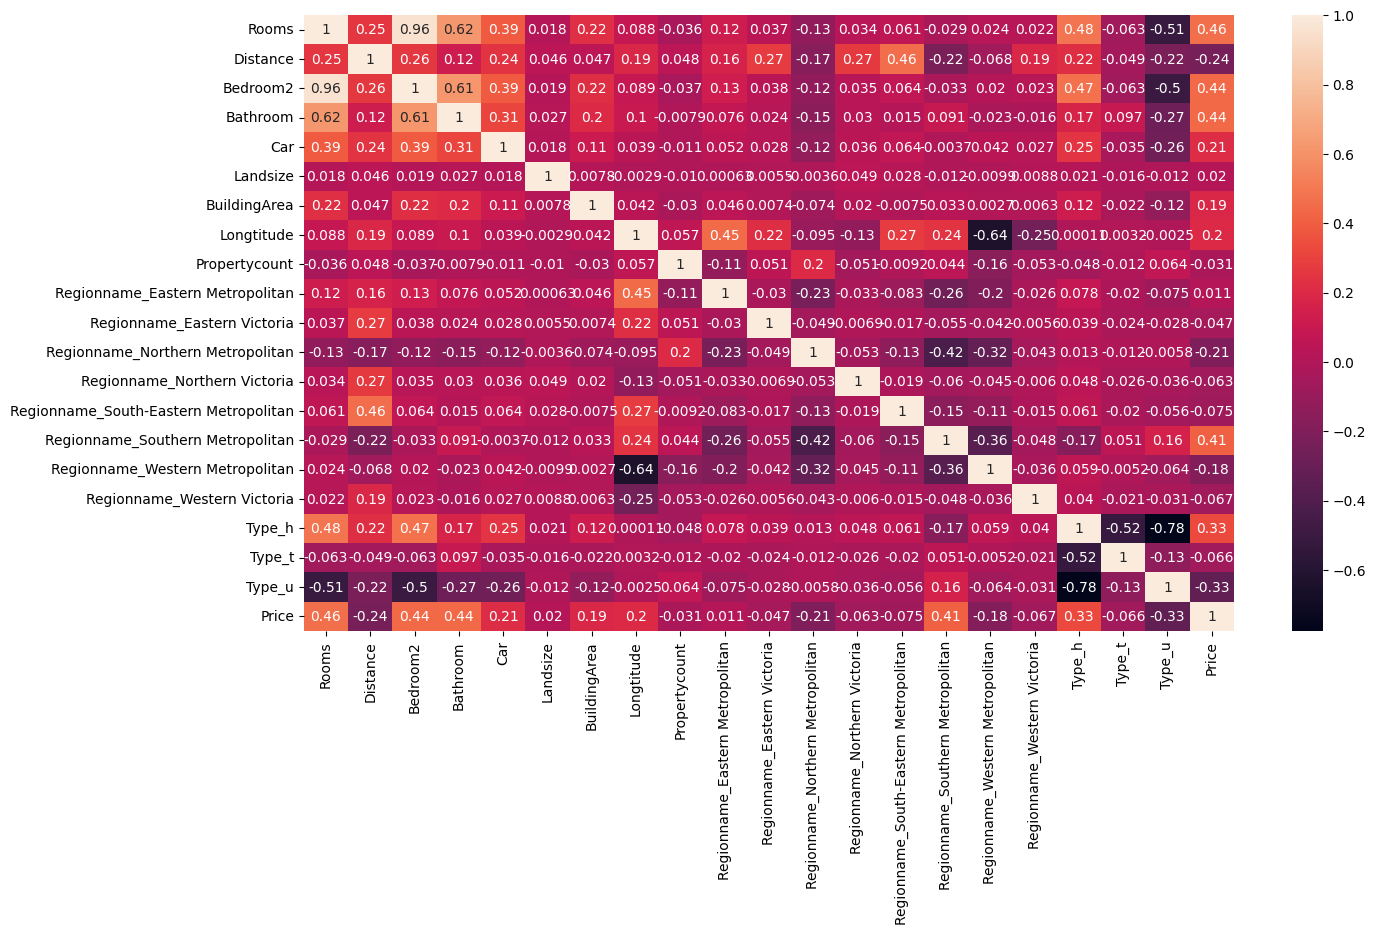

In [104]:
# Before moving futher we'll visualise the data. 
# Lets look at how different variables correlate to price. The Seaborn heatmap is a great way to view this. 
# Looking at how different values correlate to price we get a good idea on what varaibles are going to move the needle on our predicition. 
# We could take out some of the variables that arent having much correlation and see if that improves the model performance but we'll leave them in for now and see how it goes first.   

plt.figure(figsize = (15,8))
sns.heatmap(trainingData.corr(), annot=True)

array([[<Axes: title={'center': 'Rooms'}>,
        <Axes: title={'center': 'Distance'}>,
        <Axes: title={'center': 'Bedroom2'}>],
       [<Axes: title={'center': 'Bathroom'}>,
        <Axes: title={'center': 'Car'}>,
        <Axes: title={'center': 'Landsize'}>],
       [<Axes: title={'center': 'BuildingArea'}>,
        <Axes: title={'center': 'Longtitude'}>,
        <Axes: title={'center': 'Propertycount'}>],
       [<Axes: title={'center': 'Price'}>, <Axes: >, <Axes: >]],
      dtype=object)

<Figure size 2500x1000 with 0 Axes>

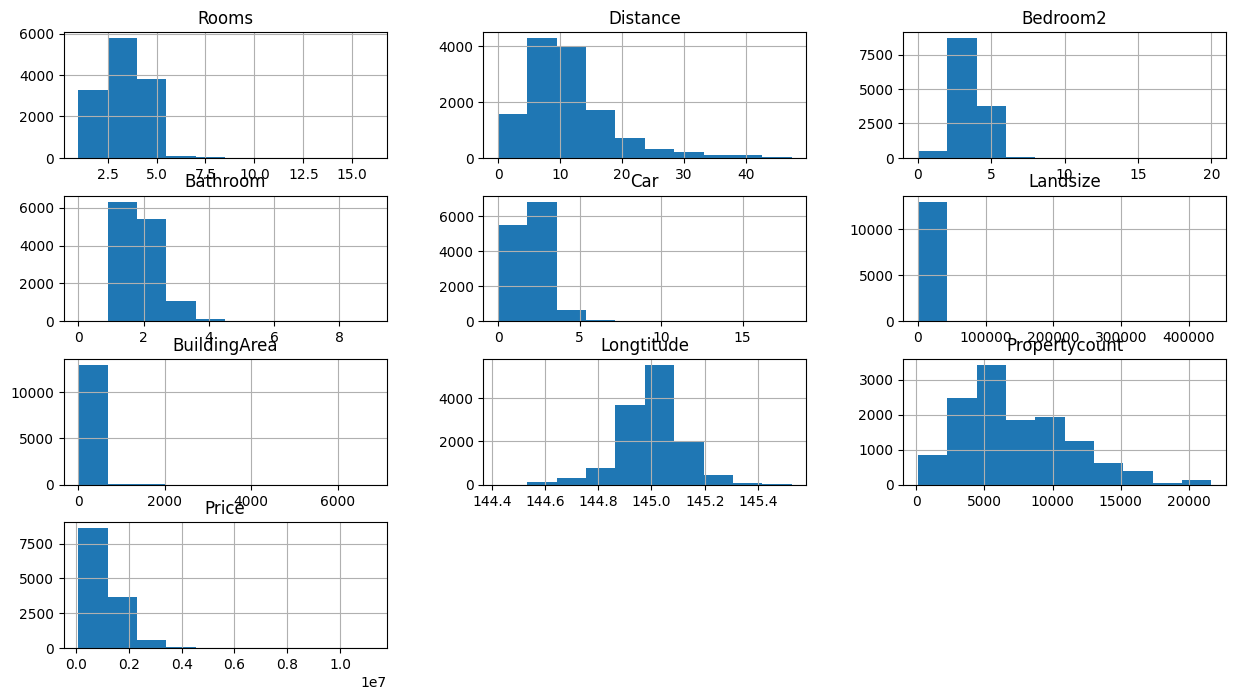

In [105]:
# Now lets look at how our data looks on a histogram. 
plt.figure(figsize=(25,10))
trainingData.hist(figsize=(15,8))

In [106]:
# Our Features are somewhat skewed, ideally we want a bell curve type distubtion 
# To do this we will be Normalising the data using logirithm from the numpy library. 
trainingData['Rooms'] = np.log (trainingData['Rooms']+1)
trainingData['Distance'] = np.log (trainingData['Distance']+1)
trainingData['Price'] = np.log (trainingData['Price']+1)
trainingData['Bedroom2'] = np.log (trainingData['Bedroom2']+1)
trainingData['Landsize'] = np.log (trainingData['Landsize']+1)
trainingData['BuildingArea'] = np.log (trainingData['BuildingArea']+1)
trainingData['Longtitude'] = np.log (trainingData['Longtitude']+1)
trainingData['Car'] = np.log (trainingData['Car']+1)
trainingData['Bathroom'] = np.log (trainingData['Bathroom']+1)




array([[<Axes: title={'center': 'Rooms'}>,
        <Axes: title={'center': 'Distance'}>,
        <Axes: title={'center': 'Bedroom2'}>],
       [<Axes: title={'center': 'Bathroom'}>,
        <Axes: title={'center': 'Car'}>,
        <Axes: title={'center': 'Landsize'}>],
       [<Axes: title={'center': 'BuildingArea'}>,
        <Axes: title={'center': 'Longtitude'}>,
        <Axes: title={'center': 'Propertycount'}>],
       [<Axes: title={'center': 'Price'}>, <Axes: >, <Axes: >]],
      dtype=object)

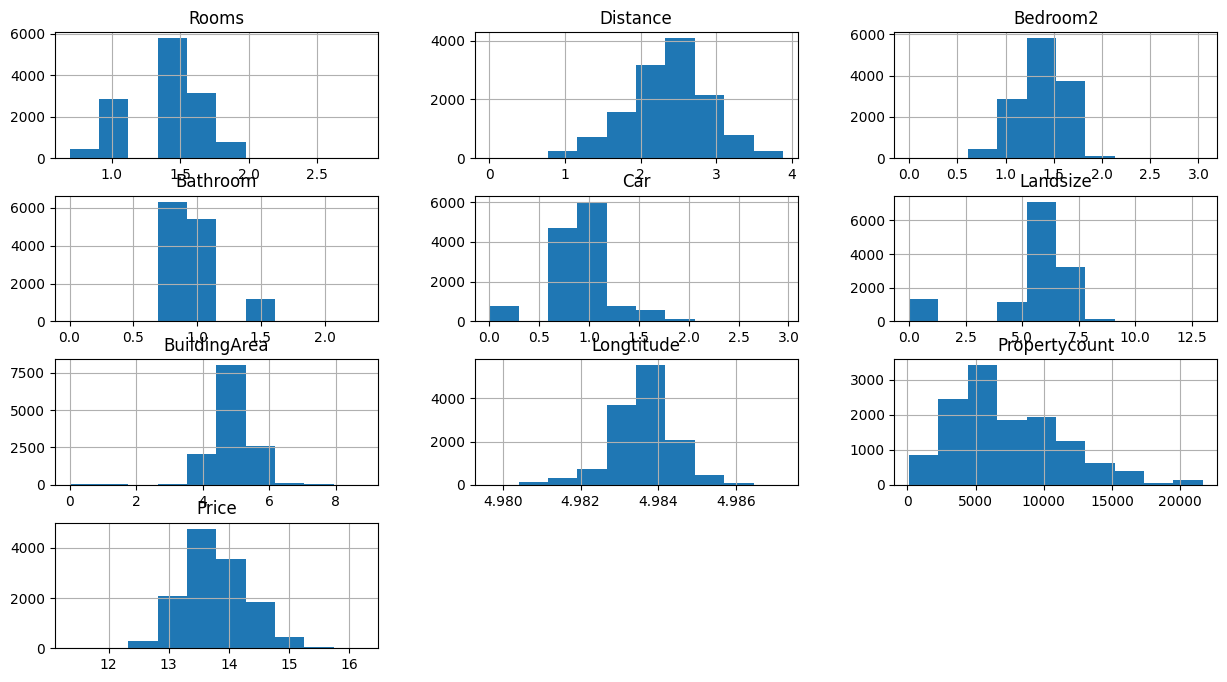

In [107]:
#Showing data after normalising with logarithms. 
trainingData.hist(figsize=(15,8))

In [108]:
# Now that we have normalised the training data we can seperate our target variable from our dataset and place it in the X_train_transform variable
# On the y variable we make it just the price variable. 
xTrainTransformed = trainingData.drop(columns=['Price'])
yTrainTransformed = trainingData['Price']



In [109]:
# Now we have what we need to build a  Linear Regression model we start by importing it in, 
# Next we name it as a variable so that we can train it later using the fit method. 
# Before we train the model we want to scale our data.

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
regressionModel = LinearRegression()
scaler = StandardScaler()
xTrainScaled= scaler.fit_transform(xTrainTransformed)
regressionModel.fit(xTrainScaled,yTrainTransformed)

LinearRegression()

In [110]:
# Now we want to configure our test data. 
# Like before we join the X and Y and then Normalise our test data using logarithms. 

testData = xTest.join(yTest)

testData['Rooms'] = np.log (testData['Rooms']+1)
testData['Distance'] = np.log (testData['Distance']+1)
testData['Price'] = np.log (testData['Price']+1)
testData['Bedroom2'] = np.log (testData['Bedroom2']+1)
testData['Landsize'] = np.log (testData['Landsize']+1)
testData['BuildingArea'] = np.log (testData['BuildingArea']+1)
testData['Landsize'] = np.log (testData['Landsize']+1)
testData['Car'] = np.log (testData['Car']+1)
testData['Bathroom'] = np.log (testData['Bathroom']+1)

In [111]:
#And we seperate the target and predictive variable again. 

xTestTransformed = trainingData.drop(columns=['Price'])
yTestTransformed = trainingData['Price']

In [112]:
# And we scale like before. 
xTestScaled = scaler.transform(xTestTransformed)

In [113]:
# Testing performance of the model using the metrics library fom sklearn.
# Firstly evaluating the r^2 value which will giive us an indication of how well the fit is.
# Mean absolute error is basically a measure of how accurate our model is and works by calculating 
# the average of the absolute differences between predicted and actual values. 
# We provide the range here too so that there is context to our evaluation metrics. 
# mse is similar to mae but is a more sensitive metrics as it squares the average differences and therefore penalises outliers. 
# rmse is another method that tells us how poorly the models predicitions are during training, the smaller the number the better. 

from sklearn import metrics 
yPred = regressionModel.predict(xTestScaled)

r2 = regressionModel.score(xTestScaled,yTestTransformed)
mae = metrics.mean_absolute_error(yTestTransformed, yPred)
mse = metrics.mean_squared_error(yTestTransformed, yPred)
rmse = np.sqrt(metrics.mean_absolute_error(yTestTransformed, yPred))
range = (np.max(yPred))-(np.min(yPred))


In [114]:
# Below prints out our evaluation metrics. Looking at the output we can see that our model is working quite well. 
print("The coefficient of determination of the model is: " + str(round(r2, 2)))
print("The range of the predicted values is: " + str(round(range, 2)))
print("The Mean absolute error of the model is: " + str(round(mae, 2)))
print("The Mean squared error regression loss of the model is: " + str(round(mse,2)))
print("The Root mean squared of the model is: " + str(round(rmse, 2)))

The coefficient of determination of the model is: 0.74
The range of the predicted values is: 3.13
The Mean absolute error of the model is: 0.21
The Mean squared error regression loss of the model is: 0.07
The Root mean squared of the model is: 0.46


In [115]:
# The score above was good, but maybe we can improve it by using a random forest, Im training that in the lines below.
from sklearn.ensemble import RandomForestRegressor

forestModel = RandomForestRegressor()
forestModel.fit(xTrainScaled, yTrainTransformed)

RandomForestRegressor()

In [117]:
#Following the same reasoning as before we run a test set through the predicition funciton of our model and evaluate the performance
yPred = forestModel.predict(xTestScaled)

r2 = forestModel.score(xTestScaled,yTestTransformed)
mae = metrics.mean_absolute_error(yTestTransformed, yPred)
mse = metrics.mean_squared_error(yTestTransformed, yPred)
rmse = np.sqrt(metrics.mean_absolute_error(yTestTransformed, yPred))
range = (np.max(yPred))-(np.min(yPred))

In [118]:
# The forest regression was much better looking at the metrics, so in our 
# implementation of this model we will access this model to base our predicitons off. 
print("The coefficient of determination of the model is: " + str(round(r2, 2)))
print("The range of the predicted values is: " + str(round(range, 2)))
print("The Mean absolute error of the model is: " + str(round(mae, 2)))
print("The Mean squared error regression loss of the model is: " + str(round(mse,2)))
print("The Root mean squared of the model is: " + str(round(rmse, 2)))

The coefficient of determination of the model is: 0.98
The range of the predicted values is: 4.07
The Mean absolute error of the model is: 0.06
The Mean squared error regression loss of the model is: 0.01
The Root mean squared of the model is: 0.23
